In [1]:
trial_number_ml = "002"
random_state_init = 420

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 14:56:02,371] A new study created in memory with name: no-name-341eaf3d-bde9-44ea-a956-4b794ea1cd10


[I 2024-05-01 14:57:27,156] Trial 0 finished with value: 0.7252130761182052 and parameters: {'n_estimators': 475, 'max_depth': 78, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7252130761182052.


[I 2024-05-01 14:58:07,410] Trial 1 finished with value: 0.7350958461585348 and parameters: {'n_estimators': 596, 'max_depth': 93, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7350958461585348.


[I 2024-05-01 14:58:37,293] Trial 2 finished with value: 0.7443386259510967 and parameters: {'n_estimators': 695, 'max_depth': 92, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 14:58:51,675] Trial 4 finished with value: 0.7433816881520535 and parameters: {'n_estimators': 447, 'max_depth': 66, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 14:58:57,987] Trial 3 finished with value: 0.738281575391867 and parameters: {'n_estimators': 928, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 14:59:09,626] Trial 8 pruned. 


[I 2024-05-01 14:59:13,372] Trial 9 pruned. 


[I 2024-05-01 14:59:20,605] Trial 5 finished with value: 0.7335004418980282 and parameters: {'n_estimators': 483, 'max_depth': 70, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 14:59:33,093] Trial 10 pruned. 


[I 2024-05-01 14:59:36,213] Trial 11 pruned. 


[I 2024-05-01 14:59:54,603] Trial 6 finished with value: 0.7312691108198986 and parameters: {'n_estimators': 562, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 15:00:10,591] Trial 7 finished with value: 0.741150357073924 and parameters: {'n_estimators': 534, 'max_depth': 99, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7443386259510967.


[I 2024-05-01 15:00:18,239] Trial 15 pruned. 


[I 2024-05-01 15:00:44,979] Trial 14 finished with value: 0.7462560570505591 and parameters: {'n_estimators': 269, 'max_depth': 97, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:01:26,788] Trial 17 pruned. 


[I 2024-05-01 15:01:42,280] Trial 12 finished with value: 0.742107294872967 and parameters: {'n_estimators': 694, 'max_depth': 80, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:01:58,859] Trial 19 pruned. 


[I 2024-05-01 15:02:00,467] Trial 13 finished with value: 0.74433507044972 and parameters: {'n_estimators': 687, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:02:06,731] Trial 20 pruned. 


[I 2024-05-01 15:02:07,457] Trial 21 pruned. 


[I 2024-05-01 15:02:24,921] Trial 22 pruned. 


[I 2024-05-01 15:02:25,364] Trial 23 pruned. 


[I 2024-05-01 15:02:44,958] Trial 18 finished with value: 0.7382805595343309 and parameters: {'n_estimators': 291, 'max_depth': 43, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:02:59,871] Trial 24 pruned. 


[I 2024-05-01 15:03:00,059] Trial 25 pruned. 


[I 2024-05-01 15:03:12,580] Trial 16 finished with value: 0.7414688284115036 and parameters: {'n_estimators': 687, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:03:39,501] Trial 28 pruned. 


[I 2024-05-01 15:03:51,738] Trial 29 pruned. 


[I 2024-05-01 15:04:18,873] Trial 30 pruned. 


[I 2024-05-01 15:04:31,800] Trial 31 pruned. 


[I 2024-05-01 15:04:52,638] Trial 33 pruned. 


[I 2024-05-01 15:04:52,663] Trial 32 pruned. 


[I 2024-05-01 15:05:05,745] Trial 35 pruned. 


[I 2024-05-01 15:05:25,142] Trial 34 pruned. 


[I 2024-05-01 15:05:25,936] Trial 36 pruned. 


[I 2024-05-01 15:05:36,533] Trial 26 finished with value: 0.744020154613517 and parameters: {'n_estimators': 642, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:05:36,882] Trial 38 pruned. 


[I 2024-05-01 15:05:44,951] Trial 37 pruned. 


[I 2024-05-01 15:06:04,626] Trial 40 pruned. 


[I 2024-05-01 15:06:06,304] Trial 39 pruned. 


[I 2024-05-01 15:06:15,943] Trial 41 pruned. 


[I 2024-05-01 15:06:32,418] Trial 27 finished with value: 0.7411528967177643 and parameters: {'n_estimators': 805, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:08:11,483] Trial 45 finished with value: 0.741150357073924 and parameters: {'n_estimators': 499, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:08:37,291] Trial 42 finished with value: 0.7405123985412285 and parameters: {'n_estimators': 749, 'max_depth': 35, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:08:38,392] Trial 46 pruned. 


[I 2024-05-01 15:08:43,953] Trial 44 finished with value: 0.7385990308719104 and parameters: {'n_estimators': 730, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:08:46,333] Trial 43 finished with value: 0.7421027235140544 and parameters: {'n_estimators': 738, 'max_depth': 41, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:08:55,891] Trial 49 pruned. 


[I 2024-05-01 15:09:16,875] Trial 48 finished with value: 0.7421047552291267 and parameters: {'n_estimators': 559, 'max_depth': 97, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 14 with value: 0.7462560570505591.


[I 2024-05-01 15:09:20,511] Trial 47 finished with value: 0.741150865002692 and parameters: {'n_estimators': 536, 'max_depth': 72, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7462560570505591.


Best trial for RandomForestClassifier:
  Value: 0.7462560570505591
  Params: 
    n_estimators: 269
    max_depth: 97
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 269, 'max_depth': 97, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 15:09:28,909] A new study created in memory with name: no-name-338897fa-867c-418e-badd-9dbc3cccf17a


RandomForestClassifier accuracy: 0.7490



[I 2024-05-01 15:09:36,155] Trial 1 finished with value: 0.7271264437875231 and parameters: {'n_estimators': 296, 'max_depth': 10, 'learning_rate': 0.22600713813847, 'min_child_weight': 6, 'subsample': 0.9072192733969353, 'colsample_bytree': 0.7848897269135158, 'gamma': 4.1036044286500175, 'reg_lambda': 0.32517135246898793, 'reg_alpha': 0.5485882744666568}. Best is trial 1 with value: 0.7271264437875231.


[I 2024-05-01 15:09:36,243] Trial 2 finished with value: 0.7427467771919665 and parameters: {'n_estimators': 105, 'max_depth': 10, 'learning_rate': 0.027544602911475383, 'min_child_weight': 7, 'subsample': 0.6511094098355661, 'colsample_bytree': 0.7112465594767711, 'gamma': 1.6513790175025678, 'reg_lambda': 0.40875754106501316, 'reg_alpha': 0.12583167008611407}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:36,367] Trial 0 finished with value: 0.732549599244202 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.016759417332363902, 'min_child_weight': 2, 'subsample': 0.8550790118707516, 'colsample_bytree': 0.5080027528313352, 'gamma': 0.6587053172370289, 'reg_lambda': 8.517496667543506, 'reg_alpha': 0.06141568617556923}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:38,822] Trial 3 finished with value: 0.7220222675971921 and parameters: {'n_estimators': 264, 'max_depth': 8, 'learning_rate': 0.25025909300028476, 'min_child_weight': 7, 'subsample': 0.6105784632414013, 'colsample_bytree': 0.9407508333199959, 'gamma': 2.4362670147984677, 'reg_lambda': 5.70199485894704, 'reg_alpha': 0.29422486084802135}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:40,876] Trial 4 finished with value: 0.7140523572974126 and parameters: {'n_estimators': 139, 'max_depth': 3, 'learning_rate': 0.16505434991370654, 'min_child_weight': 7, 'subsample': 0.6717418859762824, 'colsample_bytree': 0.56138845808717, 'gamma': 3.561328672052773, 'reg_lambda': 1.5881369251656852, 'reg_alpha': 0.03677867854400875}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:40,993] Trial 5 pruned. 


[I 2024-05-01 15:09:42,446] Trial 6 pruned. 


[I 2024-05-01 15:09:43,284] Trial 9 pruned. 


[I 2024-05-01 15:09:43,388] Trial 8 pruned. 


[I 2024-05-01 15:09:44,701] Trial 12 pruned. 


[I 2024-05-01 15:09:45,525] Trial 10 pruned. 


[I 2024-05-01 15:09:49,039] Trial 13 pruned. 


[I 2024-05-01 15:09:53,131] Trial 14 finished with value: 0.7338224687369842 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.011355539821922632, 'min_child_weight': 1, 'subsample': 0.7681563162333122, 'colsample_bytree': 0.7418228651342372, 'gamma': 0.5227926835625878, 'reg_lambda': 0.8613176664234379, 'reg_alpha': 0.10403966437184892}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:54,364] Trial 7 finished with value: 0.7277583071750018 and parameters: {'n_estimators': 369, 'max_depth': 7, 'learning_rate': 0.10343567575737489, 'min_child_weight': 6, 'subsample': 0.6543130043860256, 'colsample_bytree': 0.8492025129002698, 'gamma': 0.46264684440622206, 'reg_lambda': 3.6600851196585076, 'reg_alpha': 0.05920054062602051}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:56,330] Trial 17 pruned. 


[I 2024-05-01 15:09:56,648] Trial 15 finished with value: 0.7347804223935636 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.014134291876871541, 'min_child_weight': 1, 'subsample': 0.7323493961055606, 'colsample_bytree': 0.7903176935024157, 'gamma': 0.01679378373550733, 'reg_lambda': 0.9411204638252717, 'reg_alpha': 0.09399999841852254}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:56,772] Trial 11 finished with value: 0.7271259358587551 and parameters: {'n_estimators': 559, 'max_depth': 8, 'learning_rate': 0.1568682195157926, 'min_child_weight': 4, 'subsample': 0.6855652417410258, 'colsample_bytree': 0.6884498583077463, 'gamma': 4.742793101246552, 'reg_lambda': 0.117391570327829, 'reg_alpha': 0.25727209439225907}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:09:57,695] Trial 18 pruned. 


[I 2024-05-01 15:09:59,127] Trial 19 pruned. 


[I 2024-05-01 15:09:59,608] Trial 21 pruned. 


[I 2024-05-01 15:09:59,703] Trial 16 finished with value: 0.7395559686709536 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.07208138652371553, 'min_child_weight': 1, 'subsample': 0.7413734487810202, 'colsample_bytree': 0.7868513747252313, 'gamma': 1.6141795188301868, 'reg_lambda': 0.9297482752870171, 'reg_alpha': 0.11454887034071147}. Best is trial 2 with value: 0.7427467771919665.


[I 2024-05-01 15:10:00,942] Trial 22 pruned. 


[I 2024-05-01 15:10:01,043] Trial 24 pruned. 


[I 2024-05-01 15:10:01,288] Trial 23 pruned. 


[I 2024-05-01 15:10:02,993] Trial 26 pruned. 


[I 2024-05-01 15:10:07,797] Trial 27 finished with value: 0.7456165747315597 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.03818749050574456, 'min_child_weight': 1, 'subsample': 0.6994023092675584, 'colsample_bytree': 0.7394820421471844, 'gamma': 2.2203805257167337, 'reg_lambda': 1.818756888741736, 'reg_alpha': 0.08790608568296832}. Best is trial 27 with value: 0.7456165747315597.


[I 2024-05-01 15:10:07,934] Trial 25 finished with value: 0.7386010625869829 and parameters: {'n_estimators': 121, 'max_depth': 7, 'learning_rate': 0.03519806760483474, 'min_child_weight': 3, 'subsample': 0.802639790542406, 'colsample_bytree': 0.7728661981031976, 'gamma': 2.456786945047808, 'reg_lambda': 1.6702969278071906, 'reg_alpha': 0.09160165502146028}. Best is trial 27 with value: 0.7456165747315597.


[I 2024-05-01 15:10:09,363] Trial 20 finished with value: 0.7401903717022724 and parameters: {'n_estimators': 209, 'max_depth': 9, 'learning_rate': 0.05841589202865202, 'min_child_weight': 8, 'subsample': 0.6001904471423303, 'colsample_bytree': 0.8375169088328737, 'gamma': 1.2620425495647458, 'reg_lambda': 0.6138230149396275, 'reg_alpha': 0.010532268316124166}. Best is trial 27 with value: 0.7456165747315597.


[I 2024-05-01 15:10:09,526] Trial 30 pruned. 


[I 2024-05-01 15:10:10,720] Trial 31 pruned. 


[I 2024-05-01 15:10:11,303] Trial 32 pruned. 


[I 2024-05-01 15:10:12,313] Trial 28 finished with value: 0.7465674173853859 and parameters: {'n_estimators': 165, 'max_depth': 8, 'learning_rate': 0.03705547031848796, 'min_child_weight': 1, 'subsample': 0.6349367806676871, 'colsample_bytree': 0.6276078668490618, 'gamma': 2.130304930228856, 'reg_lambda': 1.2648674244551141, 'reg_alpha': 0.07485896891098083}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:12,514] Trial 34 pruned. 


[I 2024-05-01 15:10:14,201] Trial 35 pruned. 


[I 2024-05-01 15:10:15,160] Trial 29 finished with value: 0.7335014577555643 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.03539739829905343, 'min_child_weight': 4, 'subsample': 0.6445219250350417, 'colsample_bytree': 0.6286603634909632, 'gamma': 2.2174964179084835, 'reg_lambda': 1.8994374572641421, 'reg_alpha': 0.060266020967685914}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:15,733] Trial 36 pruned. 


[I 2024-05-01 15:10:15,906] Trial 37 pruned. 


[I 2024-05-01 15:10:16,951] Trial 38 pruned. 


[I 2024-05-01 15:10:17,700] Trial 39 pruned. 


[I 2024-05-01 15:10:18,692] Trial 41 pruned. 


[I 2024-05-01 15:10:19,583] Trial 42 pruned. 


[I 2024-05-01 15:10:19,972] Trial 43 pruned. 


[I 2024-05-01 15:10:24,991] Trial 33 finished with value: 0.737004134540172 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.03739014976750221, 'min_child_weight': 7, 'subsample': 0.6329829247406895, 'colsample_bytree': 0.7247905714467493, 'gamma': 1.1456309415293453, 'reg_lambda': 1.2900794522348988, 'reg_alpha': 0.057148514031527466}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:26,066] Trial 45 finished with value: 0.7401984985625616 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.07952010310381946, 'min_child_weight': 1, 'subsample': 0.6742706007287994, 'colsample_bytree': 0.8551948487248886, 'gamma': 1.7311197297924859, 'reg_lambda': 0.6359384866364234, 'reg_alpha': 0.2020314190734452}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:26,335] Trial 46 pruned. 


[I 2024-05-01 15:10:28,043] Trial 44 finished with value: 0.7424277979256189 and parameters: {'n_estimators': 143, 'max_depth': 8, 'learning_rate': 0.024388717507546537, 'min_child_weight': 1, 'subsample': 0.7701190096249243, 'colsample_bytree': 0.8040394109986545, 'gamma': 1.6095386996667373, 'reg_lambda': 0.6051082827999764, 'reg_alpha': 0.18769762607755053}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:28,148] Trial 40 finished with value: 0.7379641199118236 and parameters: {'n_estimators': 297, 'max_depth': 6, 'learning_rate': 0.02278749868698791, 'min_child_weight': 2, 'subsample': 0.5861868930372784, 'colsample_bytree': 0.6594906415231436, 'gamma': 2.649595054390616, 'reg_lambda': 4.573922284443262, 'reg_alpha': 0.42032547048546887}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:31,409] Trial 47 finished with value: 0.7417883156066193 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.08256888711595582, 'min_child_weight': 1, 'subsample': 0.6754411498858989, 'colsample_bytree': 0.866143912016885, 'gamma': 1.8723680413408204, 'reg_lambda': 0.6472282055206516, 'reg_alpha': 0.23903665274089198}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:32,538] Trial 48 finished with value: 0.7414703521978078 and parameters: {'n_estimators': 147, 'max_depth': 8, 'learning_rate': 0.021966711669646005, 'min_child_weight': 2, 'subsample': 0.6705175160233559, 'colsample_bytree': 0.8504427313863359, 'gamma': 1.8851218173660138, 'reg_lambda': 0.14501529253311918, 'reg_alpha': 0.5288371187328186}. Best is trial 28 with value: 0.7465674173853859.


[I 2024-05-01 15:10:33,344] Trial 49 finished with value: 0.7440247259724295 and parameters: {'n_estimators': 143, 'max_depth': 8, 'learning_rate': 0.02128938515782667, 'min_child_weight': 2, 'subsample': 0.6698237953801117, 'colsample_bytree': 0.9281665958165097, 'gamma': 1.8699605577596765, 'reg_lambda': 0.2438580406814916, 'reg_alpha': 0.47656961665173597}. Best is trial 28 with value: 0.7465674173853859.


Best trial for XGBClassifier:
  Value: 0.7465674173853859
  Params: 
    n_estimators: 165
    max_depth: 8
    learning_rate: 0.03705547031848796
    min_child_weight: 1
    subsample: 0.6349367806676871
    colsample_bytree: 0.6276078668490618
    gamma: 2.130304930228856
    reg_lambda: 1.2648674244551141
    reg_alpha: 0.07485896891098083

Best hyperparameters for XGBClassifier: {'n_estimators': 165, 'max_depth': 8, 'learning_rate': 0.03705547031848796, 'min_child_weight': 1, 'subsample': 0.6349367806676871, 'colsample_bytree': 0.6276078668490618, 'gamma': 2.130304930228856, 'reg_lambda': 1.2648674244551141, 'reg_alpha': 0.07485896891098083}


[I 2024-05-01 15:11:04,773] A new study created in memory with name: no-name-e7ea32a9-19a4-44bf-8c12-9a4da01331eb


XGBClassifier accuracy: 0.7248



[I 2024-05-01 15:11:05,433] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'max_depth': 12, 'learning_rate': 0.48986911187488996, 'n_estimators': 422, 'min_child_weight': 0.03230611547915691, 'min_child_samples': 1798, 'subsample': 0.8872292995700621, 'colsample_bytree': 0.9563035598486215, 'reg_alpha': 1.4955106482922331e-05, 'reg_lambda': 3.065109593597666e-08}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:11:07,759] Trial 0 finished with value: 0.5651814829488313 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 14, 'learning_rate': 0.029776949514898145, 'n_estimators': 228, 'min_child_weight': 0.0616538619765582, 'min_child_samples': 1125, 'subsample': 0.9911576496830855, 'colsample_bytree': 0.8726746288895455, 'reg_alpha': 5.754100016265606e-10, 'reg_lambda': 0.4370886575926151}. Best is trial 0 with value: 0.5651814829488313.


[I 2024-05-01 15:11:14,818] Trial 5 finished with value: 0.7009879214538953 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.26152040517991765, 'n_estimators': 304, 'min_child_weight': 0.005777032753456717, 'min_child_samples': 343, 'subsample': 0.8774200355257225, 'colsample_bytree': 0.9351441965554708, 'reg_alpha': 0.05048662338408085, 'reg_lambda': 2.895976191742905e-10}. Best is trial 5 with value: 0.7009879214538953.


[I 2024-05-01 15:11:17,222] Trial 6 finished with value: 0.5961143449242678 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'max_depth': 0, 'learning_rate': 0.24111131297833183, 'n_estimators': 551, 'min_child_weight': 0.009985206765033304, 'min_child_samples': 1053, 'subsample': 0.9289713342452943, 'colsample_bytree': 0.9670600553102096, 'reg_alpha': 1.981593669773851e-08, 'reg_lambda': 0.8140883651659506}. Best is trial 5 with value: 0.7009879214538953.


[I 2024-05-01 15:11:21,130] Trial 3 finished with value: 0.7150087871676876 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 7, 'learning_rate': 0.04970097645616534, 'n_estimators': 822, 'min_child_weight': 0.02436357180252344, 'min_child_samples': 79, 'subsample': 0.9202418352401559, 'colsample_bytree': 0.9685849222562386, 'reg_alpha': 0.3530784496528815, 'reg_lambda': 3.500825614904089e-07}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:22,239] Trial 7 pruned. 


[I 2024-05-01 15:11:23,919] Trial 9 finished with value: 0.6598746431800404 and parameters: {'boosting_type': 'goss', 'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.06962372916924799, 'n_estimators': 331, 'min_child_weight': 0.04347067114858704, 'min_child_samples': 442, 'subsample': 0.9581723317124372, 'colsample_bytree': 0.8541630426483727, 'reg_alpha': 2.4519592345281208e-08, 'reg_lambda': 5.963347068408513e-07}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:24,121] Trial 10 pruned. 


[I 2024-05-01 15:11:24,278] Trial 11 pruned. 


[I 2024-05-01 15:11:24,370] Trial 12 pruned. 


[I 2024-05-01 15:11:28,533] Trial 8 finished with value: 0.6783581710500919 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': 10, 'learning_rate': 0.36883453666926885, 'n_estimators': 361, 'min_child_weight': 0.001951912006608365, 'min_child_samples': 650, 'subsample': 0.9426647974655076, 'colsample_bytree': 0.8638166397030159, 'reg_alpha': 0.00017826184456981906, 'reg_lambda': 4.649749639726135e-09}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:29,037] Trial 4 pruned. 


[I 2024-05-01 15:11:45,812] Trial 13 finished with value: 0.6904565263767408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 10, 'learning_rate': 0.38704877457187015, 'n_estimators': 845, 'min_child_weight': 0.001041295873041873, 'min_child_samples': 120, 'subsample': 0.8177802273362436, 'colsample_bytree': 0.9158216221630018, 'reg_alpha': 0.009906123169027605, 'reg_lambda': 0.0002685834381440306}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:46,417] Trial 14 finished with value: 0.7016243562002864 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.13027811308522172, 'n_estimators': 841, 'min_child_weight': 0.006413785770756916, 'min_child_samples': 85, 'subsample': 0.8311296129108471, 'colsample_bytree': 0.9246286965633342, 'reg_alpha': 0.5943777006274594, 'reg_lambda': 1.1022110355915599e-10}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:47,740] Trial 15 finished with value: 0.7140569286563252 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 15, 'learning_rate': 0.12448101635715361, 'n_estimators': 706, 'min_child_weight': 0.008774820191678552, 'min_child_samples': 78, 'subsample': 0.860041692429025, 'colsample_bytree': 0.9325063917919487, 'reg_alpha': 0.48922624008760973, 'reg_lambda': 4.051271042630579e-10}. Best is trial 3 with value: 0.7150087871676876.


[I 2024-05-01 15:11:48,588] Trial 18 pruned. 


[I 2024-05-01 15:11:54,801] Trial 16 finished with value: 0.7376481882180844 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.08947482947806909, 'n_estimators': 100, 'min_child_weight': 0.009526523537613163, 'min_child_samples': 20, 'subsample': 0.8574509905570815, 'colsample_bytree': 0.800493724322156, 'reg_alpha': 0.8092563621880988, 'reg_lambda': 1.2249308955198696e-10}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:11:55,854] Trial 2 finished with value: 0.7067265006755452 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 0, 'learning_rate': 0.38953724142895974, 'n_estimators': 370, 'min_child_weight': 0.001964008673300128, 'min_child_samples': 31, 'subsample': 0.9346493218477504, 'colsample_bytree': 0.8776412078263344, 'reg_alpha': 3.4660635463992628e-09, 'reg_lambda': 3.9027740215339054e-05}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:11:56,213] Trial 21 pruned. 


[I 2024-05-01 15:11:56,581] Trial 20 pruned. 


[I 2024-05-01 15:11:56,944] Trial 22 pruned. 


[I 2024-05-01 15:11:57,337] Trial 23 pruned. 


[I 2024-05-01 15:11:58,783] Trial 19 finished with value: 0.7130949115696015 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 3, 'learning_rate': 0.12453933885349472, 'n_estimators': 670, 'min_child_weight': 0.08686817785878917, 'min_child_samples': 32, 'subsample': 0.9100653269767703, 'colsample_bytree': 0.9984862240201562, 'reg_alpha': 0.0005780579101096511, 'reg_lambda': 7.482686405261241e-06}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:00,390] Trial 17 finished with value: 0.7114989993803269 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 8, 'learning_rate': 0.11126352023380795, 'n_estimators': 726, 'min_child_weight': 0.0863025138804936, 'min_child_samples': 107, 'subsample': 0.8448990555766032, 'colsample_bytree': 0.9988209990683964, 'reg_alpha': 0.6825811892849207, 'reg_lambda': 2.3927450790317323e-05}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:04,085] Trial 25 finished with value: 0.7118276292932679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 12, 'learning_rate': 0.11607700148775321, 'n_estimators': 474, 'min_child_weight': 0.009685234787181352, 'min_child_samples': 219, 'subsample': 0.8619075925601466, 'colsample_bytree': 0.9024278692053023, 'reg_alpha': 0.08663751103660394, 'reg_lambda': 3.6942203544681864e-10}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:05,196] Trial 28 pruned. 


[I 2024-05-01 15:12:05,422] Trial 29 pruned. 


[I 2024-05-01 15:12:07,061] Trial 30 pruned. 


[I 2024-05-01 15:12:08,130] Trial 24 finished with value: 0.7102256219587765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.13289998222861266, 'n_estimators': 693, 'min_child_weight': 0.010203288434144864, 'min_child_samples': 191, 'subsample': 0.8587727718037571, 'colsample_bytree': 0.9008526193422839, 'reg_alpha': 0.03935502047264598, 'reg_lambda': 1.4844533487468026e-09}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:08,250] Trial 31 pruned. 


[I 2024-05-01 15:12:08,384] Trial 32 pruned. 


[I 2024-05-01 15:12:08,580] Trial 26 finished with value: 0.711507126240616 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.05073986003117738, 'n_estimators': 779, 'min_child_weight': 0.008893245519459431, 'min_child_samples': 240, 'subsample': 0.8677926360256338, 'colsample_bytree': 0.8980235361810509, 'reg_alpha': 0.06595869362753778, 'reg_lambda': 6.4008547459985e-10}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:08,635] Trial 33 pruned. 


[I 2024-05-01 15:12:10,390] Trial 27 finished with value: 0.7054480439663141 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 12, 'learning_rate': 0.031995088628107994, 'n_estimators': 791, 'min_child_weight': 0.010076477683475355, 'min_child_samples': 252, 'subsample': 0.8705888730347754, 'colsample_bytree': 0.9002368387028854, 'reg_alpha': 0.03728410311887092, 'reg_lambda': 1.0152910836313595e-09}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:17,153] Trial 35 finished with value: 0.71851552738244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 4, 'learning_rate': 0.09603031755337062, 'n_estimators': 660, 'min_child_weight': 0.041065378269264645, 'min_child_samples': 46, 'subsample': 0.9215380681279901, 'colsample_bytree': 0.9855177601617221, 'reg_alpha': 0.2206748118147813, 'reg_lambda': 2.9222845181269185e-06}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:18,786] Trial 37 finished with value: 0.7185170511687441 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.0901821793425443, 'n_estimators': 635, 'min_child_weight': 0.06974556506561602, 'min_child_samples': 46, 'subsample': 0.9237018146828628, 'colsample_bytree': 0.9851507160492637, 'reg_alpha': 0.17475858839077735, 'reg_lambda': 2.5048616907454065e-06}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:19,516] Trial 34 finished with value: 0.7309536870549274 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.04774134829487434, 'n_estimators': 652, 'min_child_weight': 0.06399837788882098, 'min_child_samples': 25, 'subsample': 0.9180706328965762, 'colsample_bytree': 0.984340818074439, 'reg_alpha': 0.16566114654577851, 'reg_lambda': 0.00021263314008832494}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:27,361] Trial 39 finished with value: 0.7338173894493037 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.09024488648077736, 'n_estimators': 215, 'min_child_weight': 0.05804319898070451, 'min_child_samples': 27, 'subsample': 0.9256890605717566, 'colsample_bytree': 0.9836110594618367, 'reg_alpha': 0.14910271931856284, 'reg_lambda': 0.00018912735830456493}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:28,300] Trial 41 pruned. 


[I 2024-05-01 15:12:31,207] Trial 38 finished with value: 0.7121445768445434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 5, 'learning_rate': 0.09018579950378881, 'n_estimators': 895, 'min_child_weight': 0.027053317825048294, 'min_child_samples': 30, 'subsample': 0.9261036890821703, 'colsample_bytree': 0.955208816718297, 'reg_alpha': 0.2663894333543694, 'reg_lambda': 1.484500451605845e-06}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:31,725] Trial 43 pruned. 


[I 2024-05-01 15:12:31,932] Trial 42 finished with value: 0.7153237030038907 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.47419018817409436, 'n_estimators': 182, 'min_child_weight': 0.05839101546070622, 'min_child_samples': 164, 'subsample': 0.9336189000665723, 'colsample_bytree': 0.9586840810124664, 'reg_alpha': 6.858826601637364e-05, 'reg_lambda': 0.001019569798996477}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:35,442] Trial 45 pruned. 


[I 2024-05-01 15:12:38,592] Trial 36 finished with value: 0.6993874379057081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.09618913799532594, 'n_estimators': 634, 'min_child_weight': 0.05889459822046447, 'min_child_samples': 39, 'subsample': 0.9263220150350889, 'colsample_bytree': 0.9772363550029134, 'reg_alpha': 0.20172798696754538, 'reg_lambda': 2.3016768252352257e-06}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:42,307] Trial 40 finished with value: 0.7095942665000661 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 4, 'learning_rate': 0.4922793246616105, 'n_estimators': 621, 'min_child_weight': 0.059903326954382025, 'min_child_samples': 23, 'subsample': 0.946019770231915, 'colsample_bytree': 0.9890450027790835, 'reg_alpha': 0.15723557875059485, 'reg_lambda': 0.00021848445664617825}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:44,411] Trial 47 finished with value: 0.7166062231432664 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 4, 'learning_rate': 0.14735751188943003, 'n_estimators': 269, 'min_child_weight': 0.046803114667593924, 'min_child_samples': 170, 'subsample': 0.9001117115255972, 'colsample_bytree': 0.9659445208632143, 'reg_alpha': 0.009459209610085551, 'reg_lambda': 9.083177184011439e-05}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:46,269] Trial 49 pruned. 


[I 2024-05-01 15:12:48,585] Trial 48 finished with value: 0.7248956206381617 and parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.1569865265941114, 'n_estimators': 250, 'min_child_weight': 0.04460985350371546, 'min_child_samples': 160, 'subsample': 0.8985824926786053, 'colsample_bytree': 0.9655187536294647, 'reg_alpha': 0.009882528458221464, 'reg_lambda': 7.577344810613242e-05}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:49,731] Trial 46 finished with value: 0.7335009498267964 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 4, 'learning_rate': 0.0884663730297739, 'n_estimators': 406, 'min_child_weight': 0.04948718528276519, 'min_child_samples': 27, 'subsample': 0.9217060307057017, 'colsample_bytree': 0.9771514518664345, 'reg_alpha': 0.009815189581446788, 'reg_lambda': 8.08611044023117e-05}. Best is trial 16 with value: 0.7376481882180844.


[I 2024-05-01 15:12:51,455] Trial 44 finished with value: 0.7175596054409329 and parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'max_depth': 4, 'learning_rate': 0.09687530248681625, 'n_estimators': 639, 'min_child_weight': 0.05222903275649698, 'min_child_samples': 150, 'subsample': 0.9218698557616947, 'colsample_bytree': 0.9831748707573442, 'reg_alpha': 0.14265669982537563, 'reg_lambda': 6.267285906667953e-05}. Best is trial 16 with value: 0.7376481882180844.


Best trial for LGBMClassifier:
  Value: 0.7376481882180844
  Params: 
    boosting_type: gbdt
    num_leaves: 40
    max_depth: 13
    learning_rate: 0.08947482947806909
    n_estimators: 100
    min_child_weight: 0.009526523537613163
    min_child_samples: 20
    subsample: 0.8574509905570815
    colsample_bytree: 0.800493724322156
    reg_alpha: 0.8092563621880988
    reg_lambda: 1.2249308955198696e-10

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.08947482947806909, 'n_estimators': 100, 'min_child_weight': 0.009526523537613163, 'min_child_samples': 20, 'subsample': 0.8574509905570815, 'colsample_bytree': 0.800493724322156, 'reg_alpha': 0.8092563621880988, 'reg_lambda': 1.2249308955198696e-10}


LGBMClassifier accuracy: 0.7185
LGBMClassifier accuracy: 0.7185



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_002/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

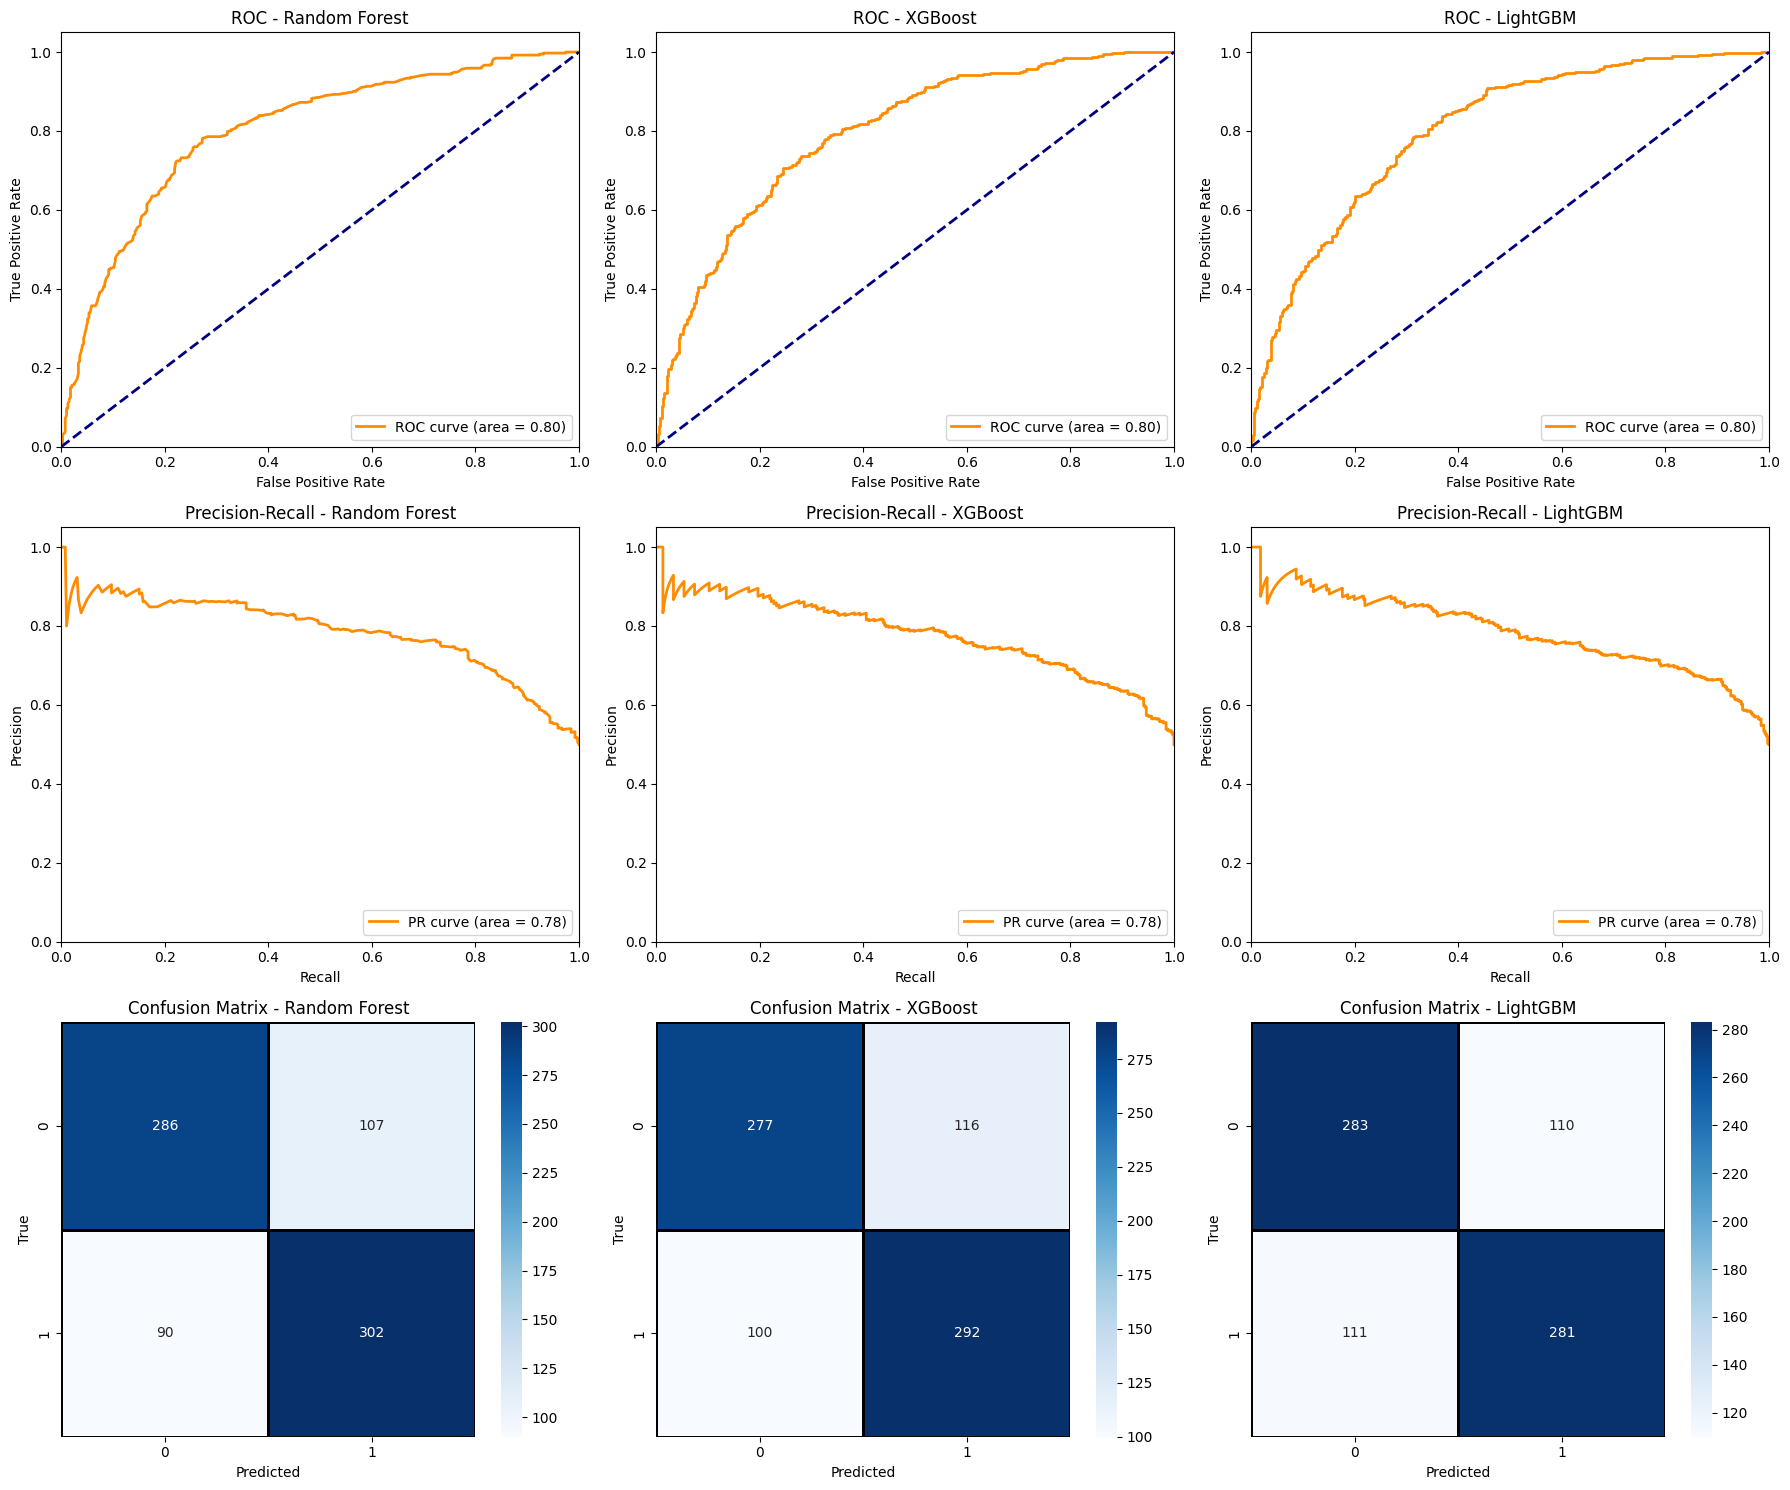

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7490445859872611, 'Precision': 0.7383863080684596, 'Recall': 0.7704081632653061, 'F1 Score': 0.7540574282147317, 'ROC AUC': 0.8017052240743625}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7248407643312101, 'Precision': 0.7156862745098039, 'Recall': 0.7448979591836735, 'F1 Score': 0.7300000000000001, 'ROC AUC': 0.795963805369476}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7184713375796178, 'Precision': 0.7186700767263428, 'Recall': 0.7168367346938775, 'F1 Score': 0.7177522349936144, 'ROC AUC': 0.8033637118969725}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7184713375796178,
 'Precision': 0.7186700767263428,
 'Recall': 0.7168367346938775,
 'F1 Score': 0.7177522349936144,
 'ROC AUC': 0.8033637118969725}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7490


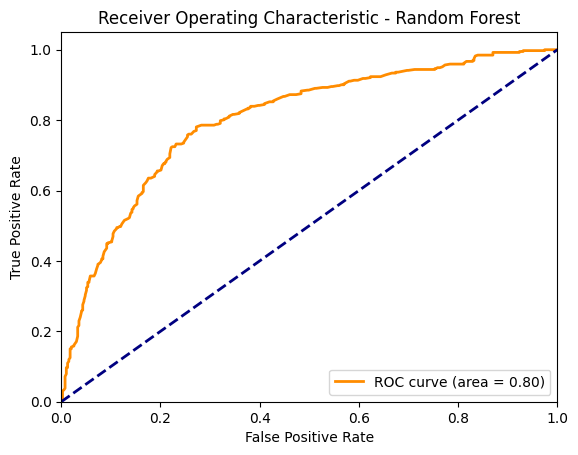

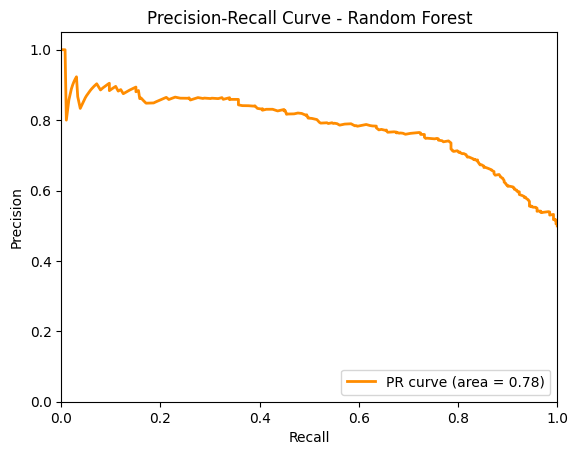

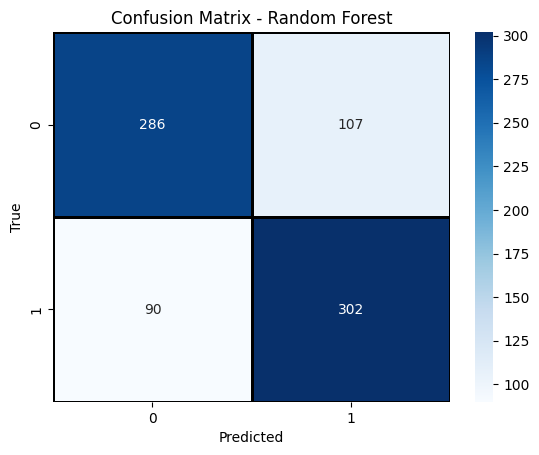

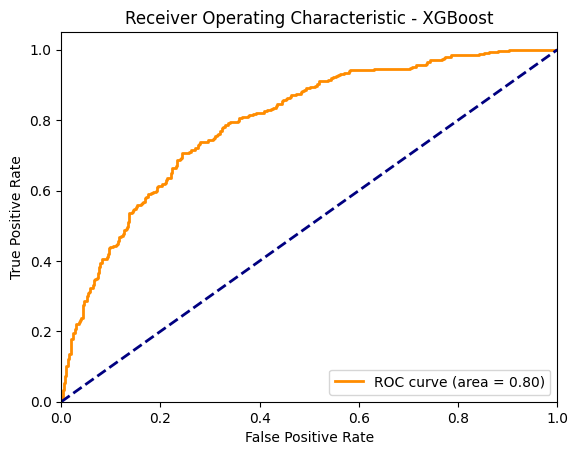

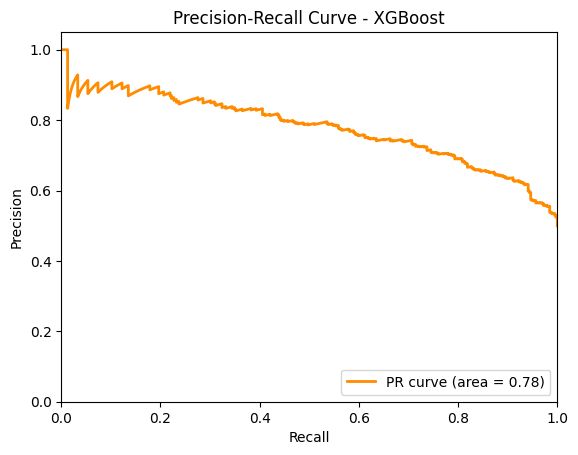

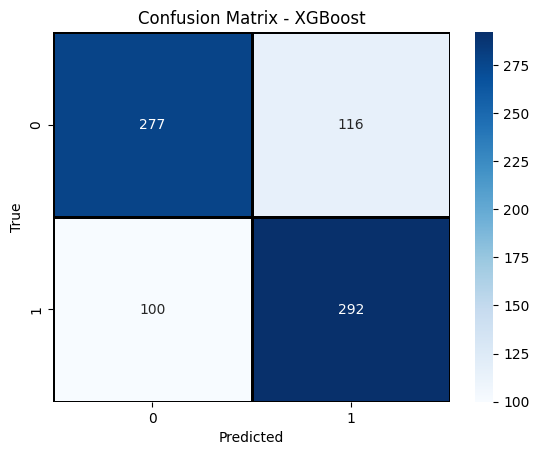

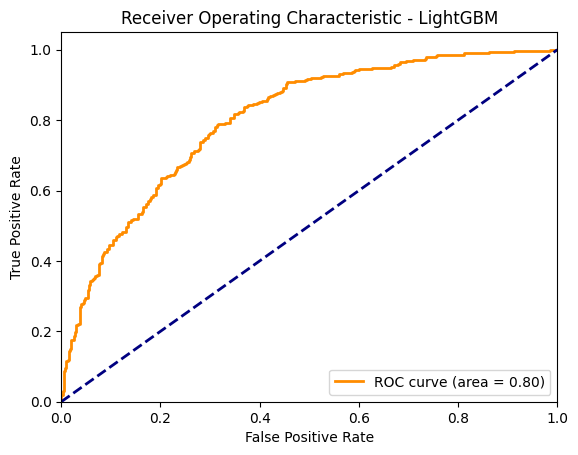

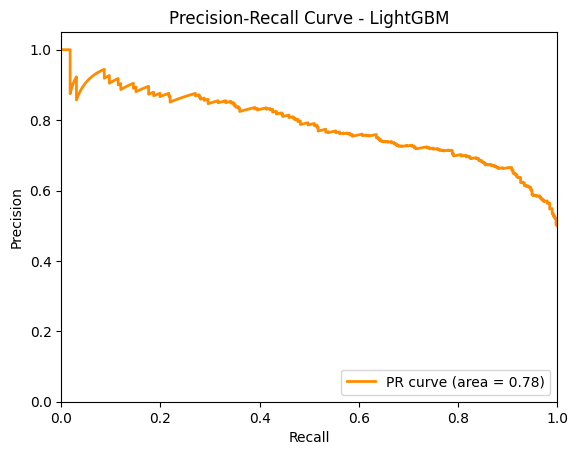

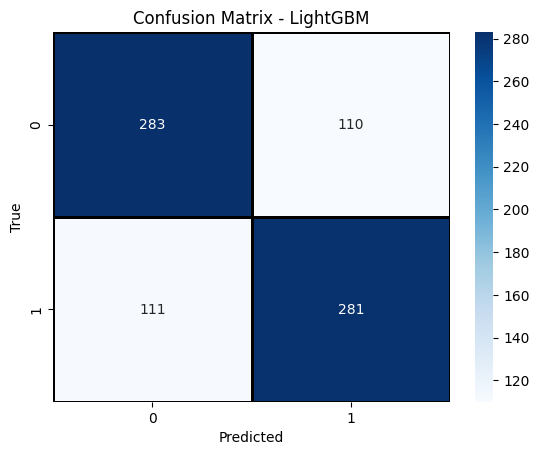

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

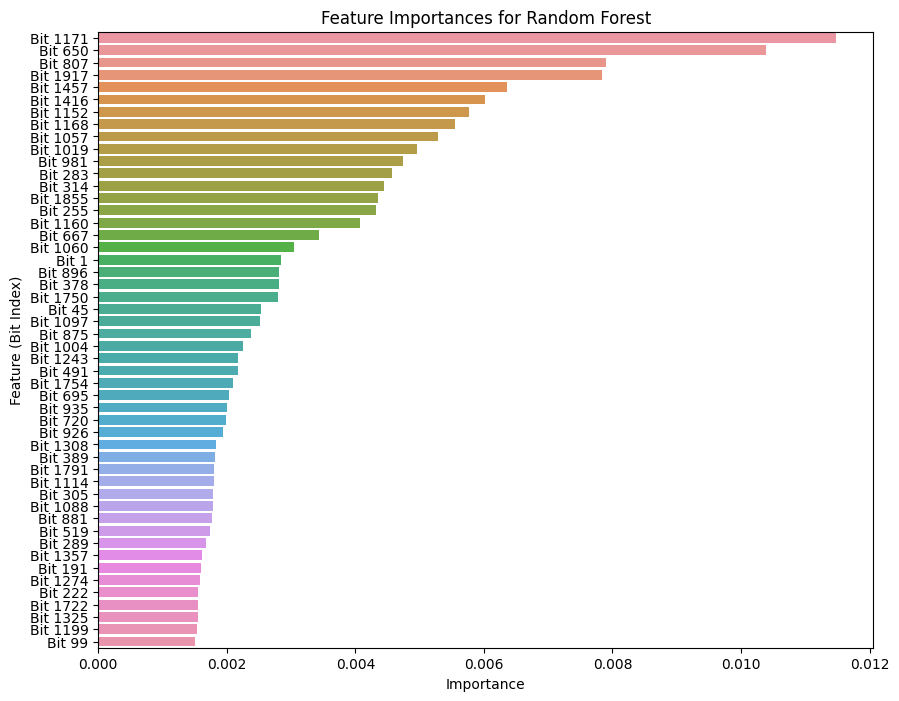

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
